In [1]:
from tmdbv3api import Movie

In [2]:
from tmdbv3api import TMDb

In [3]:
API_KEY = '5b9105a64cdd16b8cc9259f36cae74d0'

In [4]:
import requests

In [5]:
tmdb = TMDb()
tmdb.api_key = API_KEY

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
import seaborn as sns

In [7]:
from collections import Counter

In [8]:
import os 
import sys

In [9]:
from tqdm import tqdm

In [10]:
import json

In [11]:
import tqdm.notebook as tq

In [12]:
from pandas import Panel

/home/tanmay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  """Entry point for launching an IPython kernel.


In [13]:
tqdm.pandas()

/home/tanmay/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [14]:
from pandarallel import pandarallel

In [15]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [16]:
title_rating = pd.read_csv('processed/title_rating.csv')

In [23]:
title_rating.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,num_genres
0,tt0000502,movie,Bohemios,Bohemios,0,1970-01-01 00:00:00.000001905,NaN,100.0,,4.5,14,0
1,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1970-01-01 00:00:00.000001906,NaN,70.0,"Action,Adventure,Biography",6.0,754,3
2,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1970-01-01 00:00:00.000001907,NaN,90.0,Drama,4.6,17,1
3,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1970-01-01 00:00:00.000001907,NaN,NaN,Drama,4.5,23,1
4,tt0000630,movie,Hamlet,Amleto,0,1970-01-01 00:00:00.000001908,NaN,NaN,Drama,3.8,24,1


In [18]:
title_rating.genres.fillna('', inplace = True)

We have 11,666 values that need to be imputed

In [19]:
crew = pd.read_csv('processed/title_rating_crew.csv')
principal = pd.read_csv('processed/title_rating_principal.csv')

In [20]:
crew['directors'].replace({'\\N': ''}, inplace = True)
crew['writers'].replace({'\\N': ''}, inplace = True)
principal['nconst'].replace({'\\N': ''}, inplace = True)

In [36]:
names = pd.read_csv('processed/name_basics.csv')

In [22]:
title_rating['num_genres'] = title_rating['genres'].progress_apply(lambda x: len(x.split(',')) if x != '' else 0)

100%|██████████| 323834/323834 [00:00<00:00, 913625.19it/s] 


In [27]:
title_rating[title_rating['num_genres'] > 0]['num_genres'].mean()

1.7094128802439712

/home/tanmay/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


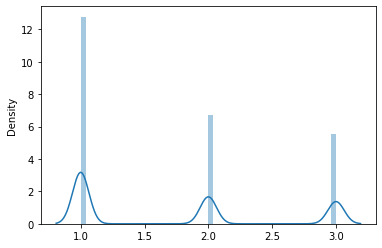

In [29]:
sns.distplot(a = title_rating[title_rating['num_genres'] > 0]['num_genres'].values )

In [30]:
#creating some useful data stuctures for further processing
title_genre = title_rating[['tconst', 'genres']]

In [32]:
def split_names(x):
    
    """
    A df function that will split a string of names for further processing
    """
    
    return [n for n in x.split(',') if (not pd.isna(x) and not x == '')]

In [33]:
title_genre['genres'] = title_genre['genres'].apply(lambda x: split_names(x))

/home/tanmay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
## Creating a mapping between title and genres for the imputation function described later
title_genre_dict = title_genre.set_index('tconst').to_dict()['genres']

In [37]:
names['knownForTitles'].fillna('', inplace = True)

In [38]:
names = names[['nconst', 'knownForTitles']]

In [39]:
names['knownForTitles'] = names['knownForTitles'].apply(lambda x: split_names(x))


In [42]:
names

,nconst,knownForTitles
0,nm0000001,"[tt0050419, tt0031983, tt0072308, tt0053137]"
1,nm0000002,"[tt0037382, tt0038355, tt0071877, tt0117057]"
2,nm0000003,"[tt0057345, tt0056404, tt0054452, tt0049189]"
3,nm0000004,"[tt0080455, tt0078723, tt0072562, tt0077975]"
4,nm0000005,"[tt0050986, tt0083922, tt0060827, tt0069467]"
...,...,...
964582,nm9993616,[tt4844148]
964583,nm9993650,[tt8739208]
964584,nm9993690,[tt7888884]
964585,nm9993691,[tt7888884]


In [41]:
names['nconst'].dropna(inplace = True) 

In [43]:
#Creating a mapping between names and known titles for the imputation function described later
names_title_dict = names.set_index('nconst').to_dict()['knownForTitles']

In [44]:
def impute_genre(title, names_title_dict, 
                 title_genre_dict, 
                 principal,
                 crew):
    """
    Function to impute the the genre of a movie. Designed to worked with df.apply
    
    params
    
    title: id of the title to be imputed
    names_title_dict: dict which maps the name of a professional to their known works
    title_genre_dict: maps titles to their respective genres
    principal: The principal dataframe
    crew: the Crew dataframe
    
    returns
    A string which is a comma separated list of genres
    """
    
    people = set()
    
    #Getting al the people that have worked on that title
    people.update(principal[principal['tconst'] == title]['nconst'].values)
    people.update(split_names(crew[crew['tconst'] == title]['directors'].values[0]))
    people.update(split_names(crew[crew['tconst'] == title]['writers'].values[0]))
    
    related = set()
#     print(people)
    #Getting all the tiles that the crew have worked on previously
    for p in people:
#         print(names_title_dict[p])
        try:
            related.update(names_title_dict[p])
        except:
            pass
    # getting the counts of the genres 
    genres = []
    for r in related:
        try:
            genres = genres+title_genre_dict[r]
        except:
            pass
        
    c = Counter(genres)
    comm = c.most_common(1)
#     print(comm)
    impute = []
    #Returning the 2 most common genres that the crew has worked on
    for item in comm:
        impute.append(item[0])
        
    return impute
    

In [45]:
#Imputing the values into the title_genre map
for key in tqdm(title_genre_dict.keys(), position=0, leave=True):
    if title_genre_dict[key] == []:
        title_genre_dict[key] = impute_genre(key, names_title_dict, 
                                             title_genre_dict, 
                                             principal,
                                             crew)
        

100%|██████████| 323834/323834 [42:13<00:00, 127.83it/s]  


In [46]:
#Saving for later use
with open('processed/title_genre_dict_2.json', 'w') as f:
    json.dump(title_genre_dict, f)

In [47]:
#Converting the lists into string compatip\ble with the original dataset
for k in tqdm(list(title_genre_dict.keys()),  position=0, leave=True):
    title_genre_dict[k] = ','.join(title_genre_dict[k])

100%|██████████| 323834/323834 [00:00<00:00, 1545721.84it/s]


In [48]:
t_g_df = pd.DataFrame.from_dict(title_genre_dict, orient='index')

In [50]:
t_g_df

,0
tt0000502,Comedy
tt0000574,"Action,Adventure,Biography"
tt0000591,Drama
tt0000615,Drama
tt0000630,Drama
...,...
tt9916362,"Drama,History"
tt9916428,"Adventure,History,War"
tt9916460,Comedy
tt9916538,Drama


In [51]:
title_genre_new = pd.merge(title_genre, t_g_df, left_on='tconst', right_on=t_g_df.index)

In [67]:
title_genre_new

,tconst,genres,0
0,tt0000502,[],Comedy
1,tt0000574,"[Action, Adventure, Biography]","Action,Adventure,Biography"
2,tt0000591,[Drama],Drama
3,tt0000615,[Drama],Drama
4,tt0000630,[Drama],Drama
...,...,...,...
323829,tt9916362,"[Drama, History]","Drama,History"
323830,tt9916428,"[Adventure, History, War]","Adventure,History,War"
323831,tt9916460,[Comedy],Comedy
323832,tt9916538,[Drama],Drama


In [68]:
title_rating

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,num_genres
0,tt0000502,movie,Bohemios,Bohemios,0,1970-01-01 00:00:00.000001905,NaN,100.0,,4.5,14,0
1,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1970-01-01 00:00:00.000001906,NaN,70.0,"Action,Adventure,Biography",6.0,754,3
2,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1970-01-01 00:00:00.000001907,NaN,90.0,Drama,4.6,17,1
3,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1970-01-01 00:00:00.000001907,NaN,NaN,Drama,4.5,23,1
4,tt0000630,movie,Hamlet,Amleto,0,1970-01-01 00:00:00.000001908,NaN,NaN,Drama,3.8,24,1
...,...,...,...,...,...,...,...,...,...,...,...,...
323829,tt9916362,movie,Coven,Akelarre,0,2020-01-01,NaN,92.0,"Drama,History",6.4,4447,2
323830,tt9916428,movie,The Secret of China,Hong xing zhao yao Zhong guo,0,2019-01-01,NaN,NaN,"Adventure,History,War",3.8,14,3
323831,tt9916460,tvMovie,Pink Taxi,Pink Taxi,0,2019-01-01,NaN,NaN,Comedy,9.3,17,1
323832,tt9916538,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,0,2019-01-01,NaN,123.0,Drama,8.3,6,1


In [69]:
#Merging our imputed data with our original dataset
title_rating_new = pd.merge(title_rating, title_genre_new, left_on='tconst', right_on = 'tconst')

In [70]:
title_rating_new

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres_x,averageRating,numVotes,num_genres,genres_y,0
0,tt0000502,movie,Bohemios,Bohemios,0,1970-01-01 00:00:00.000001905,NaN,100.0,,4.5,14,0,[],Comedy
1,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1970-01-01 00:00:00.000001906,NaN,70.0,"Action,Adventure,Biography",6.0,754,3,"[Action, Adventure, Biography]","Action,Adventure,Biography"
2,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1970-01-01 00:00:00.000001907,NaN,90.0,Drama,4.6,17,1,[Drama],Drama
3,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1970-01-01 00:00:00.000001907,NaN,NaN,Drama,4.5,23,1,[Drama],Drama
4,tt0000630,movie,Hamlet,Amleto,0,1970-01-01 00:00:00.000001908,NaN,NaN,Drama,3.8,24,1,[Drama],Drama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323829,tt9916362,movie,Coven,Akelarre,0,2020-01-01,NaN,92.0,"Drama,History",6.4,4447,2,"[Drama, History]","Drama,History"
323830,tt9916428,movie,The Secret of China,Hong xing zhao yao Zhong guo,0,2019-01-01,NaN,NaN,"Adventure,History,War",3.8,14,3,"[Adventure, History, War]","Adventure,History,War"
323831,tt9916460,tvMovie,Pink Taxi,Pink Taxi,0,2019-01-01,NaN,NaN,Comedy,9.3,17,1,[Comedy],Comedy
323832,tt9916538,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,0,2019-01-01,NaN,123.0,Drama,8.3,6,1,[Drama],Drama


In [61]:
temp = pd.read_csv('processed/title_rating_new.csv')

In [62]:
temp = temp[['tconst','runtimeMinutes', 'averageRating']]

In [63]:
temp

,tconst,runtimeMinutes,averageRating
0,tt0000502,100.0,4.5
1,tt0000574,70.0,6.0
2,tt0000591,90.0,4.6
3,tt0000615,96.0,4.5
4,tt0000630,130.0,3.8
...,...,...,...
323829,tt9916362,92.0,6.4
323830,tt9916428,93.0,3.8
323831,tt9916460,10.0,9.3
323832,tt9916538,123.0,8.3


In [71]:
title_rating_new = pd.merge(title_rating_new, temp, on='tconst')

In [73]:
title_rating_new.columns

Index([          'tconst',        'titleType',     'primaryTitle',
          'originalTitle',          'isAdult',        'startYear',
                'endYear', 'runtimeMinutes_x',         'genres_x',
        'averageRating_x',         'numVotes',       'num_genres',
               'genres_y',                  0, 'runtimeMinutes_y',
        'averageRating_y'],
      dtype='object')

In [74]:
title_rating_new.drop(columns=['runtimeMinutes_x',         'genres_x',
        'averageRating_x'], inplace = True)

In [75]:
title_rating_new

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,numVotes,num_genres,genres_y,0,runtimeMinutes_y,averageRating_y
0,tt0000502,movie,Bohemios,Bohemios,0,1970-01-01 00:00:00.000001905,NaN,14,0,[],Comedy,100.0,4.5
1,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1970-01-01 00:00:00.000001906,NaN,754,3,"[Action, Adventure, Biography]","Action,Adventure,Biography",70.0,6.0
2,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1970-01-01 00:00:00.000001907,NaN,17,1,[Drama],Drama,90.0,4.6
3,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1970-01-01 00:00:00.000001907,NaN,23,1,[Drama],Drama,96.0,4.5
4,tt0000630,movie,Hamlet,Amleto,0,1970-01-01 00:00:00.000001908,NaN,24,1,[Drama],Drama,130.0,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
323829,tt9916362,movie,Coven,Akelarre,0,2020-01-01,NaN,4447,2,"[Drama, History]","Drama,History",92.0,6.4
323830,tt9916428,movie,The Secret of China,Hong xing zhao yao Zhong guo,0,2019-01-01,NaN,14,3,"[Adventure, History, War]","Adventure,History,War",93.0,3.8
323831,tt9916460,tvMovie,Pink Taxi,Pink Taxi,0,2019-01-01,NaN,17,1,[Comedy],Comedy,10.0,9.3
323832,tt9916538,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,0,2019-01-01,NaN,6,1,[Drama],Drama,123.0,8.3


In [76]:
title_rating_new.to_csv("processed/title_genre_new_2.csv", index = False)

In [77]:
cc_df = pd.read_csv('processed/cc_df.csv')

In [78]:
title_rating_prof = pd.merge(title_rating_new, cc_df, on='tconst', how='left')

In [79]:
title_rating_prof

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,numVotes,num_genres,genres_y,...,Unnamed: 0,nconst,cast_mean,cast_std,cast_max,crew_mean,crew_std,crew_max,cast_exp,crew_exp
0,tt0000502,movie,Bohemios,Bohemios,0,1970-01-01 00:00:00.000001905,NaN,14,0,[],...,0.0,"['nm0215752', 'nm0252720', 'nm0063413', 'nm065...",4.500000,NaN,4.500000,5.357143,1.016246,6.366667,1.000000,5.000000
1,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1970-01-01 00:00:00.000001906,NaN,754,3,"[Action, Adventure, Biography]",...,1.0,"['nm0675239', 'nm0846887', 'nm0846894', 'nm143...",6.000000,NaN,6.000000,5.802778,NaN,6.033333,1.000000,1.833333
2,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1970-01-01 00:00:00.000001907,NaN,17,1,[Drama],...,2.0,"['nm0906197', 'nm0332182', 'nm1323543', 'nm175...",5.178571,NaN,5.725000,4.800000,0.282843,5.000000,4.000000,2.000000
3,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1970-01-01 00:00:00.000001907,NaN,23,1,[Drama],...,3.0,"['nm3071427', 'nm0581353', 'nm0888988', 'nm024...",4.800000,NaN,5.100000,4.766667,NaN,5.133333,1.333333,2.333333
4,tt0000630,movie,Hamlet,Amleto,0,1970-01-01 00:00:00.000001908,NaN,24,1,[Drama],...,4.0,"['nm0624446', 'nm0143333', 'nm0000636', 'nm020...",5.337500,1.242302,6.650000,5.801958,1.409807,7.575000,4.500000,163.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323829,tt9916362,movie,Coven,Akelarre,0,2020-01-01,NaN,4447,2,"[Drama, History]",...,323106.0,"['nm5813626', 'nm3766704', 'nm0107165', 'nm026...",6.148864,NaN,7.575000,6.353927,NaN,7.028571,17.750000,6.428571
323830,tt9916428,movie,The Secret of China,Hong xing zhao yao Zhong guo,0,2019-01-01,NaN,14,3,"[Adventure, History, War]",...,323107.0,"['nm3611859', 'nm9445072', 'nm8594703', 'nm042...",4.542778,NaN,5.083333,4.691667,1.100755,6.000000,4.500000,7.500000
323831,tt9916460,tvMovie,Pink Taxi,Pink Taxi,0,2019-01-01,NaN,17,1,[Comedy],...,323108.0,"['nm8796794', 'nm10538444', 'nm8691452', 'nm10...",9.300000,NaN,9.300000,9.300000,NaN,9.300000,1.000000,1.000000
323832,tt9916538,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,0,2019-01-01,NaN,6,1,[Drama],...,323109.0,"['nm4700236', 'nm8678236', 'nm1417182', 'nm100...",7.267708,NaN,8.300000,7.083557,NaN,8.300000,9.250000,15.555556


In [80]:
title_rating_prof.to_csv('processed/title_rating_prof_2.csv', index = False)

In [81]:
title_rating_akas = pd.read_csv('processed/title_rating_aka.csv')

In [82]:
title_rating_akas

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000502,movie,Bohemios,Bohemios,0,1970-01-01 00:00:00.000001905,NaN,100.0,NaN,4.5,14,tt0000502,1,Bohemios,\N,\N,original,\N,1
1,tt0000502,movie,Bohemios,Bohemios,0,1970-01-01 00:00:00.000001905,NaN,100.0,NaN,4.5,14,tt0000502,2,Bohemios,ES,\N,imdbDisplay,\N,0
2,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1970-01-01 00:00:00.000001906,NaN,70.0,"Action,Adventure,Biography",6.0,754,tt0000574,10,The Story of the Kelly Gang,AU,\N,imdbDisplay,\N,0
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1970-01-01 00:00:00.000001906,NaN,70.0,"Action,Adventure,Biography",6.0,754,tt0000574,1,Kelly bandájának története,HU,\N,imdbDisplay,\N,0
4,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1970-01-01 00:00:00.000001906,NaN,70.0,"Action,Adventure,Biography",6.0,754,tt0000574,2,Ned Kelly and His Gang,AU,\N,imdbDisplay,\N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105360,tt9916428,movie,The Secret of China,Hong xing zhao yao Zhong guo,0,2019-01-01,NaN,NaN,"Adventure,History,War",3.8,14,tt9916428,5,Hong xing zhao yao Zhong guo,CN,\N,\N,\N,0
2105361,tt9916460,tvMovie,Pink Taxi,Pink Taxi,0,2019-01-01,NaN,NaN,Comedy,9.3,17,tt9916460,1,Ροζ Ταξί,GR,\N,imdbDisplay,\N,0
2105362,tt9916460,tvMovie,Pink Taxi,Pink Taxi,0,2019-01-01,NaN,NaN,Comedy,9.3,17,tt9916460,2,Pink Taxi,\N,\N,original,\N,1
2105363,tt9916538,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,0,2019-01-01,NaN,123.0,Drama,8.3,6,tt9916538,1,Kuambil Lagi Hatiku,ID,\N,\N,\N,0


In [83]:
#Get the number of regions each title was featured in
regions_df = title_rating_akas.groupby('tconst').agg({'title':'count'})


In [84]:
title_rating_prof_reg = pd.merge(title_rating_prof, regions_df, left_on='tconst', right_on=regions_df.index, how = 'left')

In [85]:
title_rating_prof_reg.rename(columns={'title':'numRegions'}, inplace=True)

In [86]:
title_rating_prof_reg.to_csv('processed/title_rating_prof_reg_2.csv')

In [91]:
title_rating_prof_reg.rename(columns={0:'genres'}, inplace = True)

In [92]:
title_rating_prof_reg

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,numVotes,num_genres,genres_y,...,nconst,cast_mean,cast_std,cast_max,crew_mean,crew_std,crew_max,cast_exp,crew_exp,numRegions
0,tt0000502,movie,Bohemios,Bohemios,0,1970-01-01 00:00:00.000001905,NaN,14,0,[],...,"['nm0215752', 'nm0252720', 'nm0063413', 'nm065...",4.500000,NaN,4.500000,5.357143,1.016246,6.366667,1.000000,5.000000,2.0
1,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1970-01-01 00:00:00.000001906,NaN,754,3,"[Action, Adventure, Biography]",...,"['nm0675239', 'nm0846887', 'nm0846894', 'nm143...",6.000000,NaN,6.000000,5.802778,NaN,6.033333,1.000000,1.833333,10.0
2,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1970-01-01 00:00:00.000001907,NaN,17,1,[Drama],...,"['nm0906197', 'nm0332182', 'nm1323543', 'nm175...",5.178571,NaN,5.725000,4.800000,0.282843,5.000000,4.000000,2.000000,3.0
3,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1970-01-01 00:00:00.000001907,NaN,23,1,[Drama],...,"['nm3071427', 'nm0581353', 'nm0888988', 'nm024...",4.800000,NaN,5.100000,4.766667,NaN,5.133333,1.333333,2.333333,2.0
4,tt0000630,movie,Hamlet,Amleto,0,1970-01-01 00:00:00.000001908,NaN,24,1,[Drama],...,"['nm0624446', 'nm0143333', 'nm0000636', 'nm020...",5.337500,1.242302,6.650000,5.801958,1.409807,7.575000,4.500000,163.500000,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323829,tt9916362,movie,Coven,Akelarre,0,2020-01-01,NaN,4447,2,"[Drama, History]",...,"['nm5813626', 'nm3766704', 'nm0107165', 'nm026...",6.148864,NaN,7.575000,6.353927,NaN,7.028571,17.750000,6.428571,21.0
323830,tt9916428,movie,The Secret of China,Hong xing zhao yao Zhong guo,0,2019-01-01,NaN,14,3,"[Adventure, History, War]",...,"['nm3611859', 'nm9445072', 'nm8594703', 'nm042...",4.542778,NaN,5.083333,4.691667,1.100755,6.000000,4.500000,7.500000,5.0
323831,tt9916460,tvMovie,Pink Taxi,Pink Taxi,0,2019-01-01,NaN,17,1,[Comedy],...,"['nm8796794', 'nm10538444', 'nm8691452', 'nm10...",9.300000,NaN,9.300000,9.300000,NaN,9.300000,1.000000,1.000000,2.0
323832,tt9916538,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,0,2019-01-01,NaN,6,1,[Drama],...,"['nm4700236', 'nm8678236', 'nm1417182', 'nm100...",7.267708,NaN,8.300000,7.083557,NaN,8.300000,9.250000,15.555556,1.0


## Final Imputation and Clean-Up

This section fills out any nulls missed in the previous steps

In [93]:
title_rating_prof_reg.isnull().sum()

tconst                   0
titleType                0
primaryTitle             0
originalTitle            0
isAdult                  0
startYear               34
endYear             323834
numVotes                 0
num_genres               0
genres_y                 0
genres                   0
runtimeMinutes_y         0
averageRating_y          0
Unnamed: 0             723
nconst                 723
cast_mean              723
cast_std            150713
cast_max               723
crew_mean              723
crew_std            155979
crew_max               723
cast_exp               723
crew_exp               723
numRegions            1084
dtype: int64

In [94]:
#Imputing mean performance with the over all-mean
title_rating_prof_reg.cast_mean.fillna(6.2, inplace=True)
title_rating_prof_reg.crew_mean.fillna(6.2, inplace=True)

In [95]:
#Imputing std with 0 (these people have worked only on one title)

title_rating_prof_reg.cast_std.fillna(0, inplace=True)
title_rating_prof_reg.crew_std.fillna(0, inplace=True)

In [96]:
#Imputing max with the mean of the max 

title_rating_prof_reg.cast_max.fillna(6.6, inplace=True)
title_rating_prof_reg.crew_max.fillna(6.6, inplace=True)

In [97]:
#Imputing experience with a value of 1 

title_rating_prof_reg.cast_exp.fillna(1, inplace=True)
title_rating_prof_reg.crew_exp.fillna(1, inplace=True)

In [98]:
#Imputing numregions with 1 (The movie has to be featured in atleast one region)

title_rating_prof_reg.numRegions.fillna(1, inplace=True)


In [99]:
title_rating_prof_reg.isnull().sum()

tconst                   0
titleType                0
primaryTitle             0
originalTitle            0
isAdult                  0
startYear               34
endYear             323834
numVotes                 0
num_genres               0
genres_y                 0
genres                   0
runtimeMinutes_y         0
averageRating_y          0
Unnamed: 0             723
nconst                 723
cast_mean                0
cast_std                 0
cast_max                 0
crew_mean                0
crew_std                 0
crew_max                 0
cast_exp                 0
crew_exp                 0
numRegions               0
dtype: int64